# Brain Tumor Detection - 4-Class Classification (Colab)

**Author:** User
**Description:** Training VGG-16 for 4-class brain tumor classification (Glioma, Meningioma, No Tumor, Pituitary).
**Features:**
- Direct Dataset Upload (.zip)
- Data Visualization
- Transfer Learning (VGG16)
- Performance Metrics & Plots

## 1. Setup & GPU Check

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Check for GPU
print("TensorFlow Version:", tf.__version__)
if tf.config.list_physical_devices('GPU'):
    print("✅ GPU is available.")
else:
    print("⚠️ GPU NOT DETECTED. Go to Runtime > Change runtime type > T4 GPU")

TensorFlow Version: 2.19.0
✅ GPU is available.


## 2. Upload Dataset
Run this cell to upload your `dataset.zip` file directly from your computer.

In [2]:
# Upload dataset
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Extract
if 'dataset.zip' in uploaded:
    print("Extracting dataset.zip...")
    with zipfile.ZipFile('dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/dataset')
    print("✅ Extraction Complete!")
else:
    print("⚠️ dataset.zip not found in upload. Please confirm filename.")

EXTRACT_PATH = '/content/dataset'
TRAIN_DIR = os.path.join(EXTRACT_PATH, 'Training')
TEST_DIR = os.path.join(EXTRACT_PATH, 'Testing')

Saving dataset.zip to dataset.zip
User uploaded file "dataset.zip" with length 318500332 bytes
Extracting dataset.zip...
✅ Extraction Complete!


## 3. Visualize Dataset
Let's look at some sample images from each class.

Sample Images from Training Set:


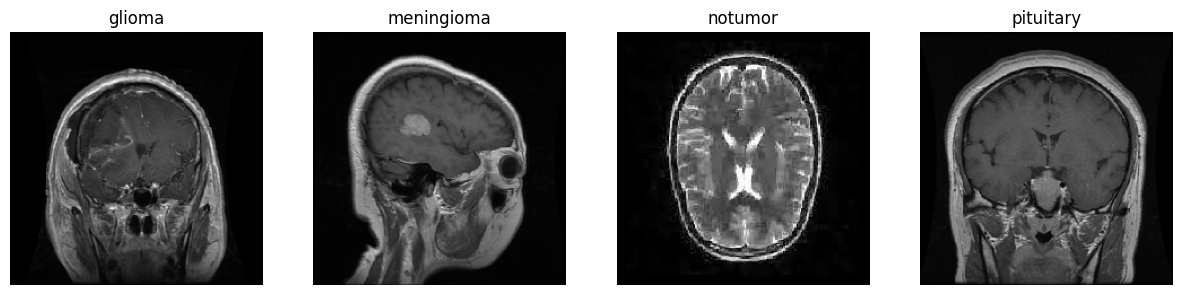

In [6]:
CLASSES = ["glioma", "meningioma", "notumor", "pituitary"]

def plot_samples(titles, images):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

print("Sample Images from Training Set:")
sample_images = []
sample_titles = []

for label in CLASSES:
    class_dir = os.path.join(TRAIN_DIR, label)
    if os.path.exists(class_dir) and len(os.listdir(class_dir)) > 0:
        img_name = os.listdir(class_dir)[0]
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(224, 224))
        sample_images.append(img)
        sample_titles.append(label)

if sample_images:
    plot_samples(sample_titles, sample_images)

## 4. Prepare Data Generators

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

print("Loading Generators...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Loading Generators...
Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## 5. Build Model & Train

In [8]:
def build_model():
    # Using VGG16 as a layer (Nested Model) for easier fine-tuning management
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    inputs = layers.Input(shape=(224, 224, 3))
    # training=False ensures BatchNormalization layers stay in inference mode
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(4, activation='softmax')(x)

    return models.Model(inputs=inputs, outputs=outputs)

model = build_model()

# PHASE 1: Frozen Base
print("--- PHASE 1: Training Head ---")
model.compile(optimizer=optimizers.Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
history1 = model.fit(train_generator, epochs=10, validation_data=test_generator)

# PHASE 2: Fine Tuning
print("\n--- PHASE 2: Fine Tuning ---")

# Access the VGG16 base model (layer index 1 in our new architecture)
# model.layers[0] is Input
# model.layers[1] is VGG16
base_model = model.layers[1]
base_model.trainable = True

# Freeze all layers in base_model except the last 4
if hasattr(base_model, 'layers'):
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    print(f"Unfrozen last 4 layers of {base_model.name}")
else:
    print("Warning: base_model does not have .layers attribute. Check structure.")

model.compile(optimizer=optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
history2 = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

--- PHASE 1: Training Head ---
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 98s 503ms/step - accuracy: 0.6484 - loss: 1.4719 - val_accuracy: 0.8391 - val_loss: 0.4569
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 498ms/step - accuracy: 0.8330 - loss: 0.4379 - val_accuracy: 0.8680 - val_loss: 0.3567
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 493ms/step - accuracy: 0.8626 - loss: 0.3557 - val_accuracy: 0.8894 - val_loss: 0.2951
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 493ms/step - accuracy: 0.8801 - loss: 0.3168 - val_accuracy: 0.8833 - val_loss: 0.3050
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 494ms/step - accuracy: 0.8934 - loss: 0.2941 - val_accuracy: 0.8986 - val_loss: 0.2818
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 494ms/step - accuracy: 0.8967 - loss: 0.2615 - val_accuracy: 0.8993 - val_loss: 0.2482
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 89s 496ms/step - accuracy: 0.9128 - loss: 0.2289 - val_accuracy: 0.9085 - val_loss: 0.2612
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 492ms/st

## 6. Training Visualization
Plotting accuracy and loss curves.

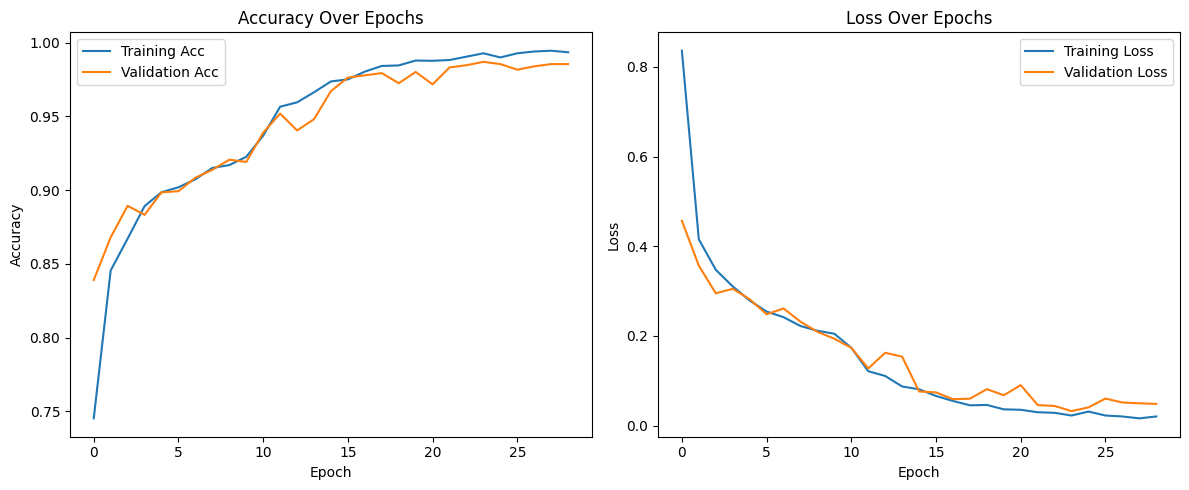

In [9]:
def plot_history(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Acc')
    plt.plot(val_acc, label='Validation Acc')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history1, history2)

## 7. Model Evaluation
Visualizing Confusion Matrix and some Prediction samples.

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step


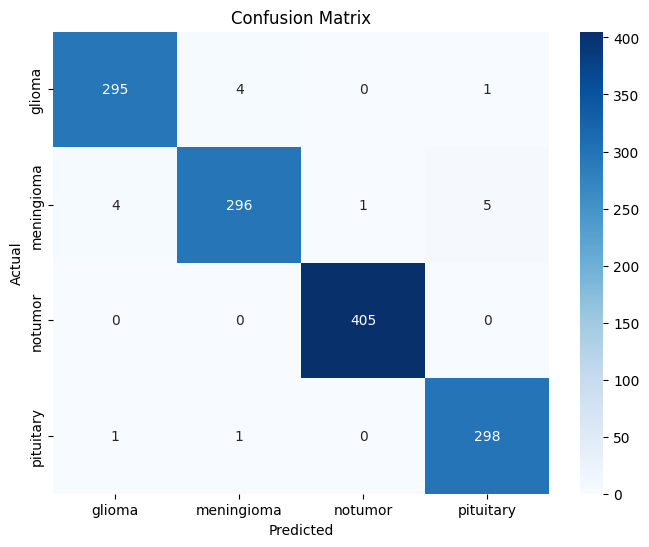


Classification Report:

              precision    recall  f1-score   support

      glioma       0.98      0.98      0.98       300
  meningioma       0.98      0.97      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [10]:
# Confusion Matrix
test_generator.reset()
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=CLASSES))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step


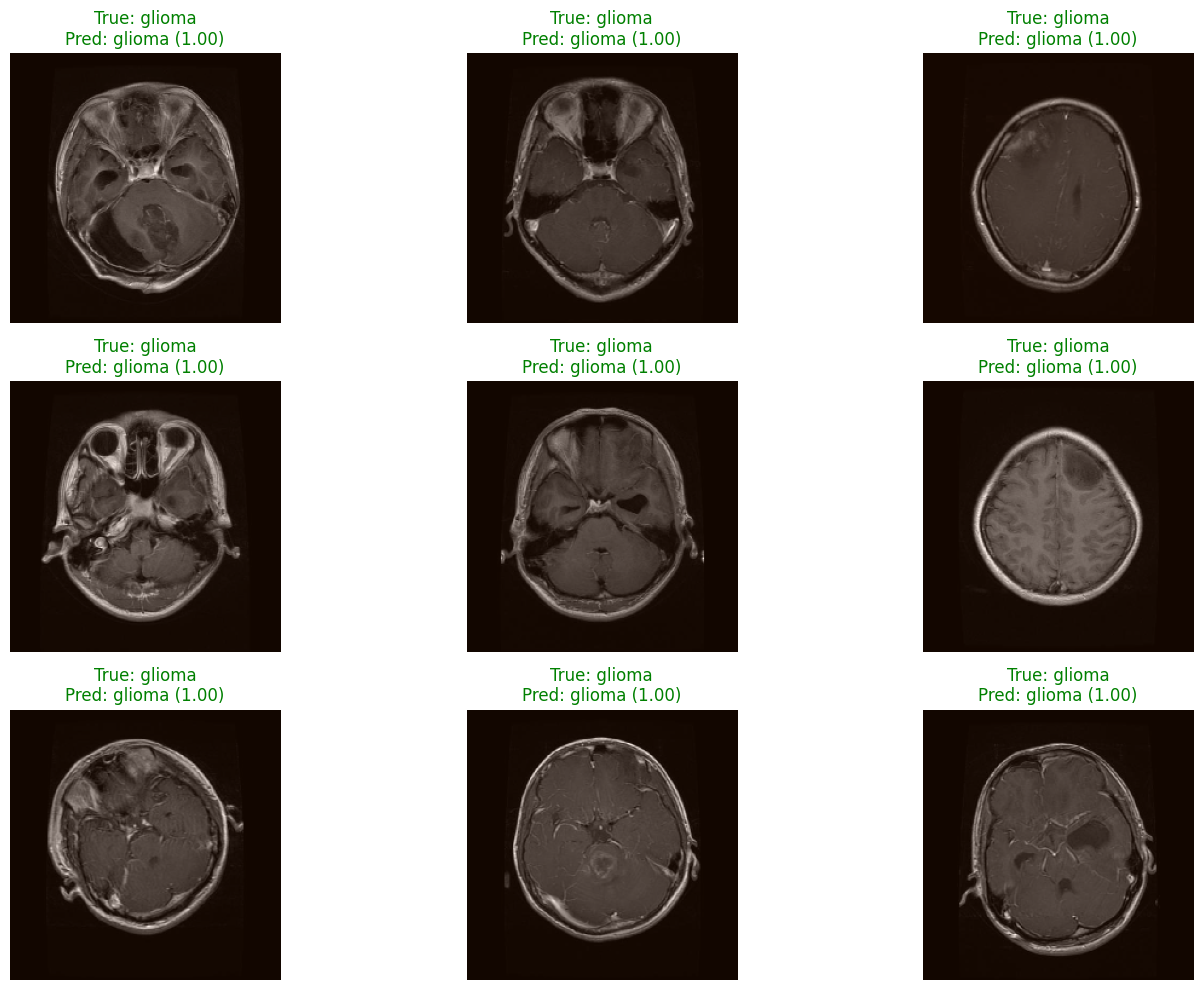

In [11]:
# Visualize Predictions
def visualize_predictions(generator, model):
    generator.reset()
    # Get one batch
    images, labels = next(generator)
    preds = model.predict(images)

    plt.figure(figsize=(15, 10))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)

        # Display image (reverse preprocess if needed, but for VGG usually just needs clipping)
        # VGG preprocess subtracts mean, so we might see weird colors.
        # For simple robust viz, we can re-load original images, but let's try to normalize for display.
        img_disp = images[i]
        img_disp = (img_disp - img_disp.min()) / (img_disp.max() - img_disp.min())

        plt.imshow(img_disp)

        true_idx = np.argmax(labels[i])
        pred_idx = np.argmax(preds[i])
        conf = np.max(preds[i])

        color = 'green' if true_idx == pred_idx else 'red'
        plt.title(f"True: {CLASSES[true_idx]}\nPred: {CLASSES[pred_idx]} ({conf:.2f})", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(test_generator, model)

## 8. Download Model

In [12]:
model.save('vgg16_brain_tumor_4class.h5')
files.download('vgg16_brain_tumor_4class.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>